# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [5]:
# Load from toy dataloader with two sessions
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/two_sessions.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/two_sessions.joblib'
two_sessions_dataloader = joblib.load(data_path)

# Train a model

Things I want to try:
- with all parameters not frozen (running now). See how it compares to the model with readout matrix frozen (0.0642). **Yes, it's a tiny bit better 1e-4.**
- Use more factors for the stimulus effect. **Yes, it improves 0.064 -> 0.063.**
- Increase the number of B-spline basis to see if it capture shift in peaks. **Yes, it improves 1e-4, but makes the function more oscillatory.**
- Use inhomogeneous baseline + var as the trial-wise stimulus effect. So the VAE only needs to learn the difference across trials.
- Compare the three steps (0.06365) training with directly training with the last step (0.06378). **Yes, it's better 2e-4.**


In [ ]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = two_sessions_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint_ipynb'

params = {
    # B-spline basis
    'num_B_spline_basis': 50,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 48,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 4,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e2,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': 1e-4,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 50,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        include_self_history=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        include_self_history=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
        'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
        'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
        record_results=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Total sessions: 2, Batch size: 64, Train set size: 264, Val set size: 40, Test set size: 78
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 24, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 2, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 1000.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_lat

100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 1/200, Train Loss: 0.2513, Test Loss: 0.0119


  8%|▊         | 20/264 [00:03<00:38,  6.30it/s]


KeyboardInterrupt: 

In [8]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")
trainer.save_model_and_hp(filename=None, test_loss=test_loss)

100%|██████████| 78/78 [00:07<00:00, 10.06it/s]

Test loss: 0.002634123768240464
Test loss baseline: 0.004554291280064614
Trainer instance (model and hyperparameters) saved to /home/qix/user_data/VAETransformer_checkpoint_ipynb/20250503_024723.pth


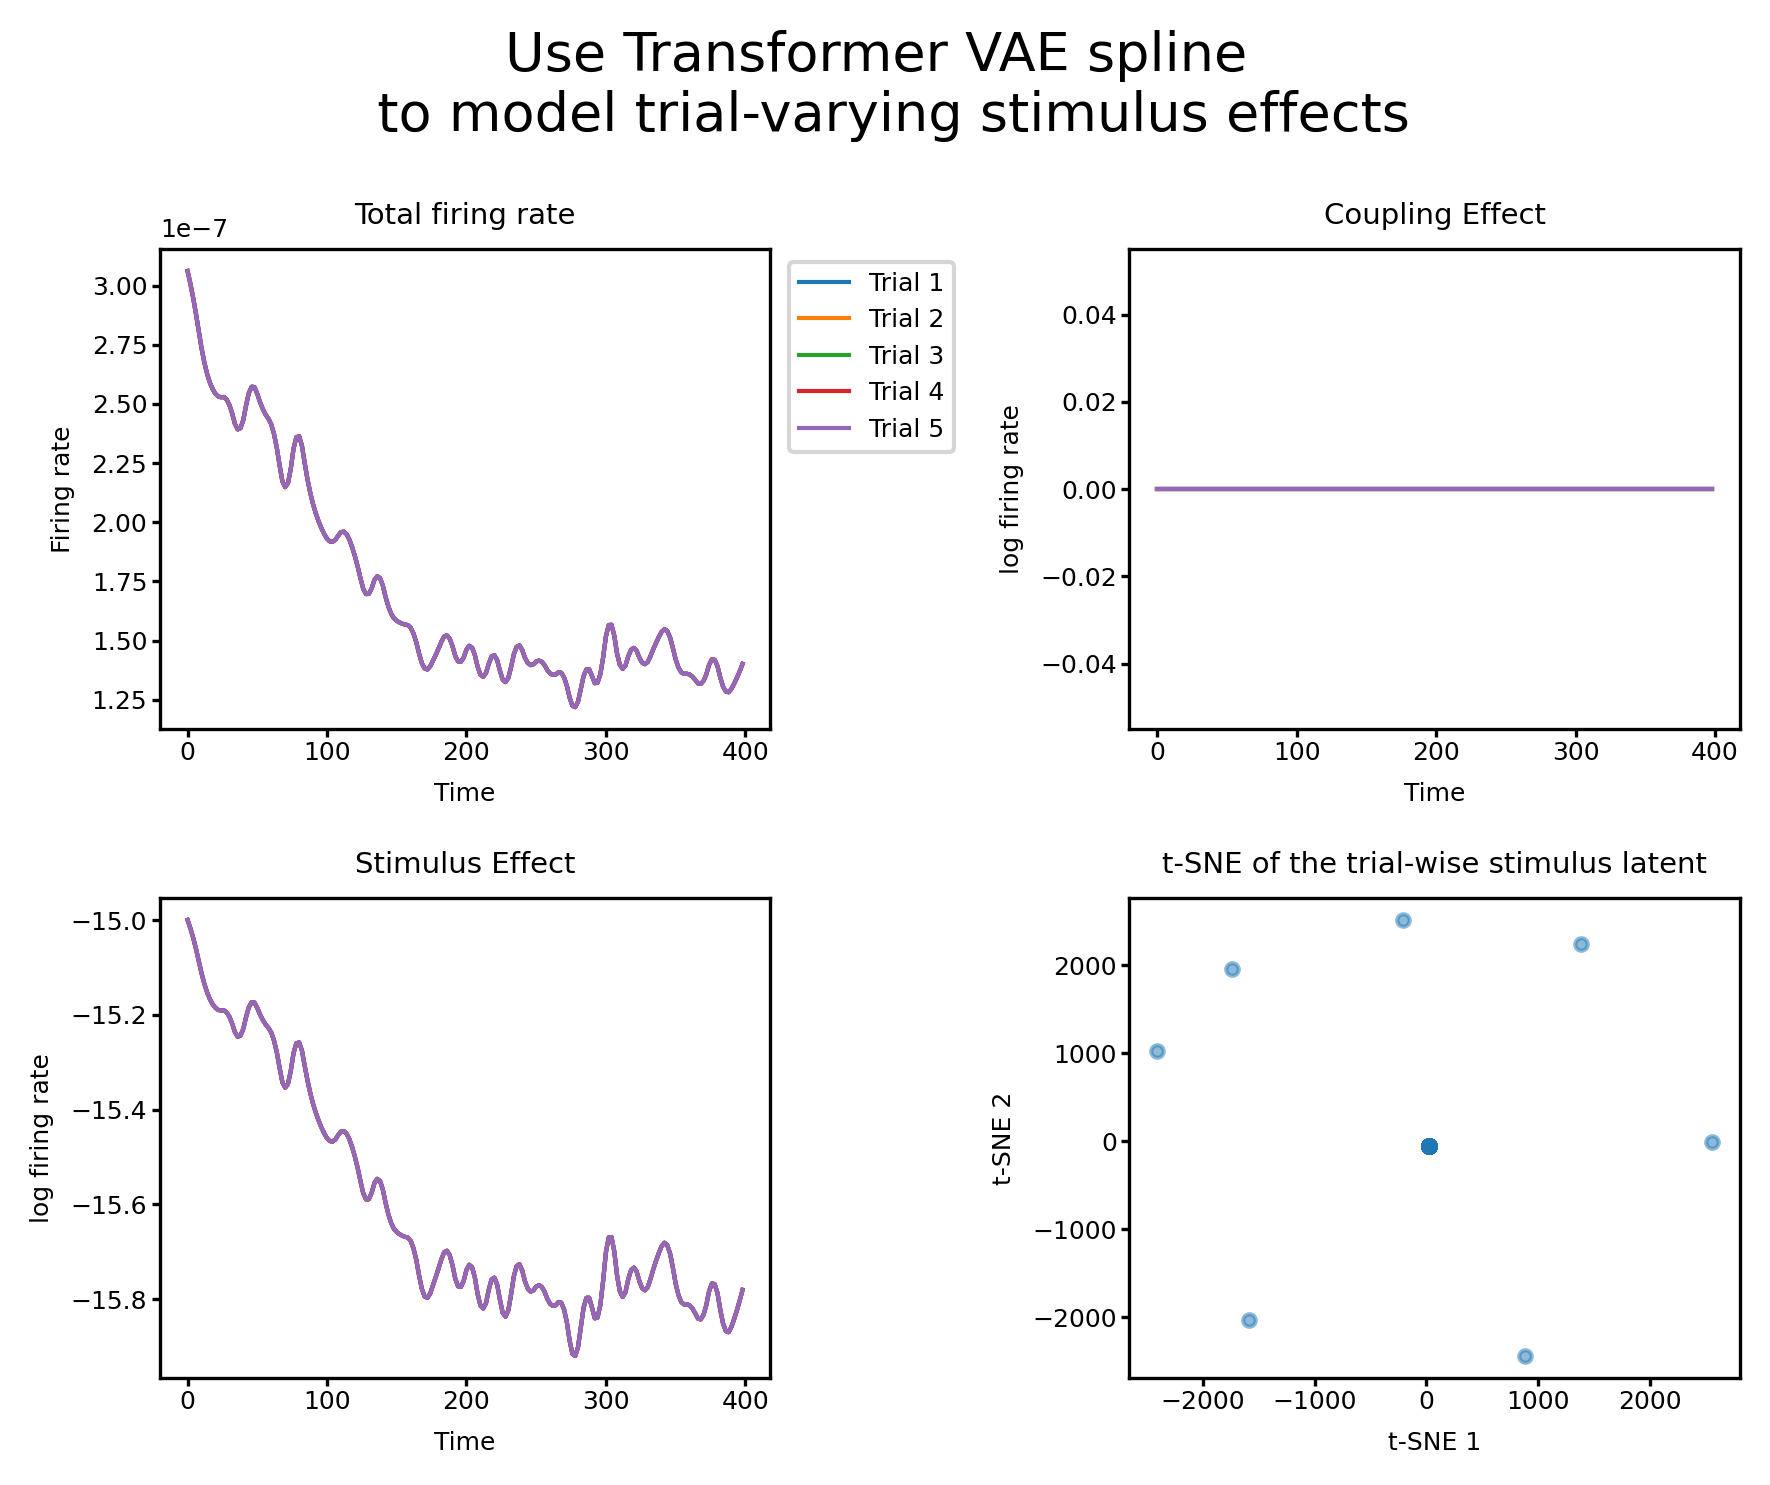

In [9]:
trial_indices = np.arange(0, 5)
neuron_idx = 35
utils.use_pdf_plot()

firing_rate_test, sti_mu_test, sti_logvar_test, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[10],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=False,
    return_spike_trains=True,
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5) ,dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
xx = np.arange(0, 400, 2)
axes[0,0].plot(xx, np.exp(firing_rate_test[:, neuron_idx, trial_indices].numpy()))
# axes[0,0].plot(xx, firing_rate_test[:, neuron_idx, trial_indices].numpy())
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
axes[0,0].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
                 bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
axes[0,1].plot(xx, trainer.model.firing_rates_coupling[trial_indices, neuron_idx, :].cpu().numpy().T)
axes[0,1].set_title('Coupling Effect')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
axes[1,0].plot(xx, trainer.model.firing_rates_stimulus[trial_indices, neuron_idx, :].cpu().numpy().T)
axes[1,0].set_title('Stimulus Effect')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
if np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
    axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
    axes[1,1].set_xlabel('t-SNE 1')
    axes[1,1].set_ylabel('t-SNE 2')
else:
    print(f"Stimulus latent is not varying across trials: {sti_mu_test_np.std(axis=0).mean()}")

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_3837667/2552613748.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


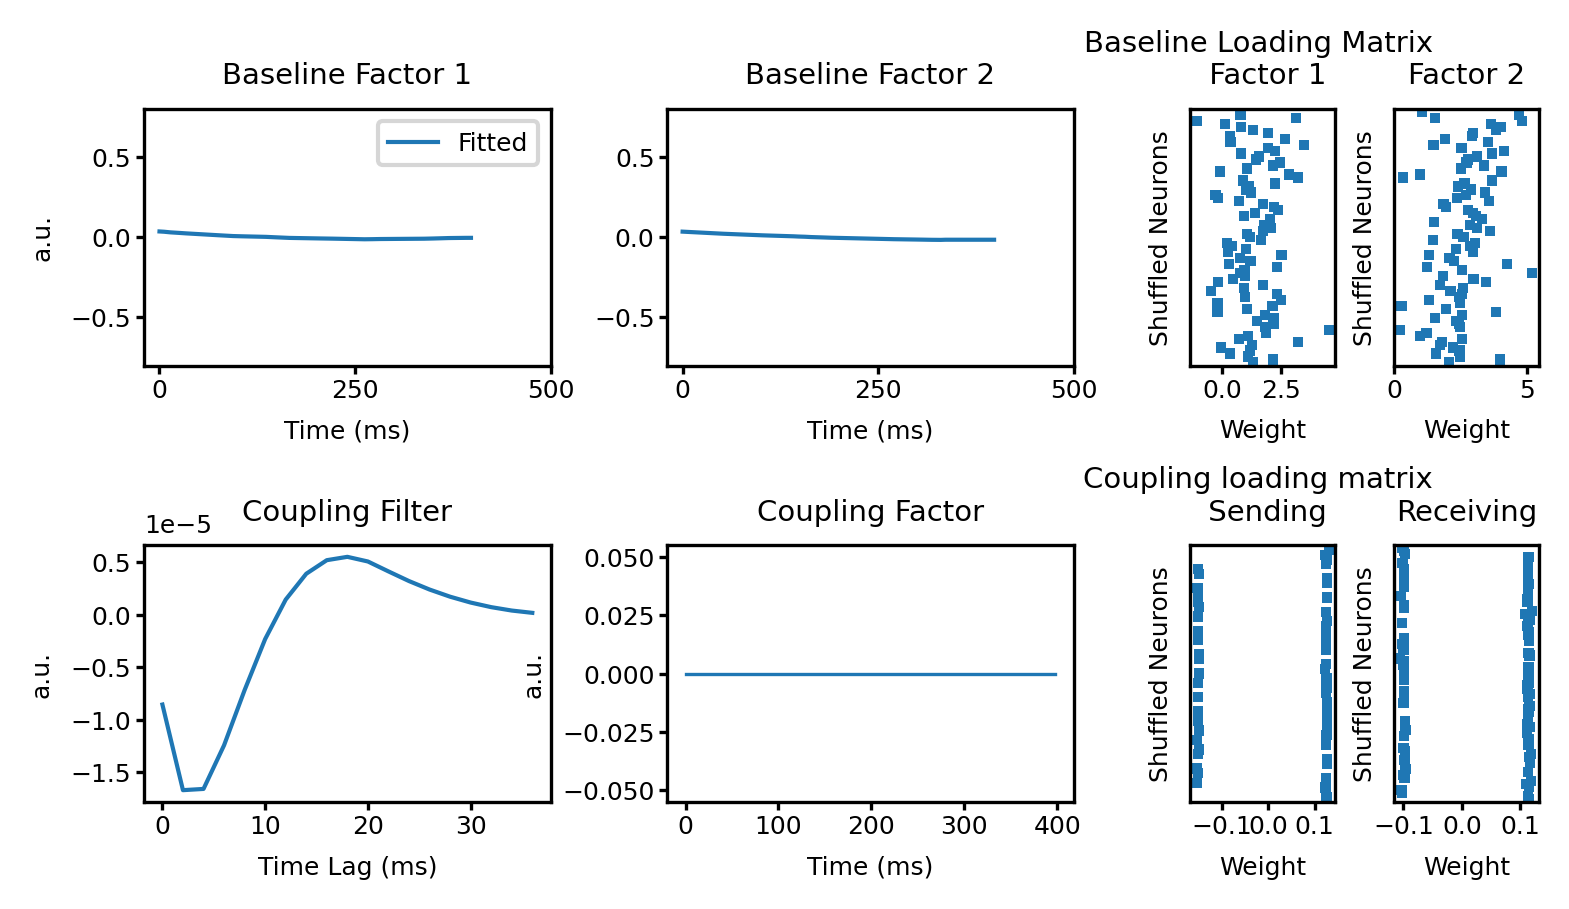

In [10]:
plot_session = str(757216464)
plot_area = 2
coupling_from = 3


# Create 2x3 subplot
utils.use_pdf_plot()
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(6, 3), dpi=300)
outer = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.7, width_ratios=[0.35, 0.35, 0.3])
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        if (i, j) not in [(0, 2), (1, 2)]:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])

# Pick a trial with intermediate fit (using middle trial)
local_trial_idx = utils.find_middle_fit_trial(
    firing_rate_test, 
    spike_train_test,
)
# global_trial_idx = trial_indices[local_trial_idx]
xx = np.arange(firing_rate_test.shape[0])*2

### First row - Baseline components
# Normalize both the ground truth and the fitted
readout_mat_fitted = trainer.model.sti_readout_matrix_dict[plot_session][plot_area].weight.detach().cpu().numpy()
# readout_mat_gt = loading_mat_baseline_list[plot_area]
fitted_rescale = np.std(readout_mat_fitted, axis=0)*np.sign(readout_mat_fitted.mean(axis=0))
# gt_rescale = np.std(readout_mat_gt, axis=0)*np.sign(readout_mat_gt.mean(axis=0))
# npadding = gt_neuron_params['npadding']

# Baseline Factor 1
# axes[0,0].plot(
#     xx,
#     utils.centralize_factor(
#         factor_baseline_rcd[npadding:, 0, global_trial_idx, plot_area]
#     *gt_rescale[0]),
#     label='Ground truth', color='tab:green', alpha=0.5
# )
axes[0,0].plot(
    xx,
    utils.centralize_factor(
       trainer.model.factors[local_trial_idx,plot_area,:,1].detach().cpu().numpy()
    *fitted_rescale[1]),
    label='Fitted', color='tab:blue'
)
axes[0,0].set_title('Baseline Factor 1')
axes[0,0].set_xlabel('Time (ms)')
axes[0,0].set_ylabel('a.u.')
axes[0,0].legend()
axes[0,0].set_ylim(-0.8, 0.8)
axes[0,0].set_xticks([0, 250, 500])
axes[0,0].set_yticks([-0.5, 0, 0.5])

# Baseline Factor 2
# axes[0,1].plot(
#     xx,
#     utils.centralize_factor(
#         factor_baseline_rcd[npadding:, 1, global_trial_idx, plot_area]
#     *gt_rescale[1]),
#     label='Ground truth', color='tab:green', alpha=0.5,
# )
axes[0,1].plot(
    xx,
    utils.centralize_factor(
        trainer.model.factors[local_trial_idx,plot_area,:,0].detach().cpu().numpy()
    *fitted_rescale[0]),
    label='Fitted', color='tab:blue',
)
axes[0,1].set_title('Baseline Factor 2')
axes[0,1].set_xlabel('Time (ms)')
# axes[0,1].set_ylabel('a.u.')
# axes[0,1].legend()
axes[0,1].set_ylim(-0.8, 0.8)
axes[0,1].set_xticks([0, 250, 500])
axes[0,1].set_yticks([-0.5, 0, 0.5])


# baseline loading matrix
# Add common title for the two inner panels
inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[0, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    None,
    readout_mat_fitted[:,1]/fitted_rescale[1],
    title="Baseline Loading Matrix \n Factor 1", 
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    None,
    readout_mat_fitted[:,0]/fitted_rescale[0],
    title="Factor 2", 
)


### Second row - Coupling part
# coupling filter
xxx = np.arange(trainer.model.coupling_filters_dict[plot_session][coupling_from][plot_area].shape[0])*2
# axes[1,0].plot(xxx,
#                (basis_coupling @ connections[0]['strength'][:,0]),
#                label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,0].plot(xxx,
               trainer.model.coupling_filters_dict[plot_session][coupling_from][plot_area].detach().cpu().numpy(),
               label='Fitted', color='tab:blue')
axes[1,0].set_title('Coupling Filter')
axes[1,0].set_xlabel('Time Lag (ms)')
axes[1,0].set_ylabel('a.u.')
# axes[1,0].legend()


# coupling filter
# axes[1,1].plot(xx,
#                factor_coupling[gt_neuron_params['npadding']:, 0, global_trial_idx],
#                label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,1].plot(xx,
               trainer.model.coupling_outputs_subspace[coupling_from][plot_area][local_trial_idx, 0, :].detach().cpu().numpy(),
               label='Fitted', color='tab:blue', lw=0.8)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time (ms)')
axes[0,1].set_xticks([0, 250, 500])
axes[1,1].set_ylabel('a.u.')
# axes[1,1].legend()


inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    None,
    trainer.model.cp_weight_sending_dict[plot_session][coupling_from][plot_area].detach().cpu().numpy(),
    title="Coupling loading matrix \n Sending", 
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    None,
    trainer.model.cp_weight_receiving_dict[plot_session][coupling_from][plot_area].detach().cpu().numpy(),
    title="Receiving", 
)

plt.tight_layout()
# plt.savefig('Figure/Figure2_GLM_ground_truth_vs_fitted.pdf', bbox_inches='tight', dpi=300)

In [11]:
firing_rate_test, sti_mu_test, sti_logvar_test, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[1],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=False,
    return_spike_trains=True,
)

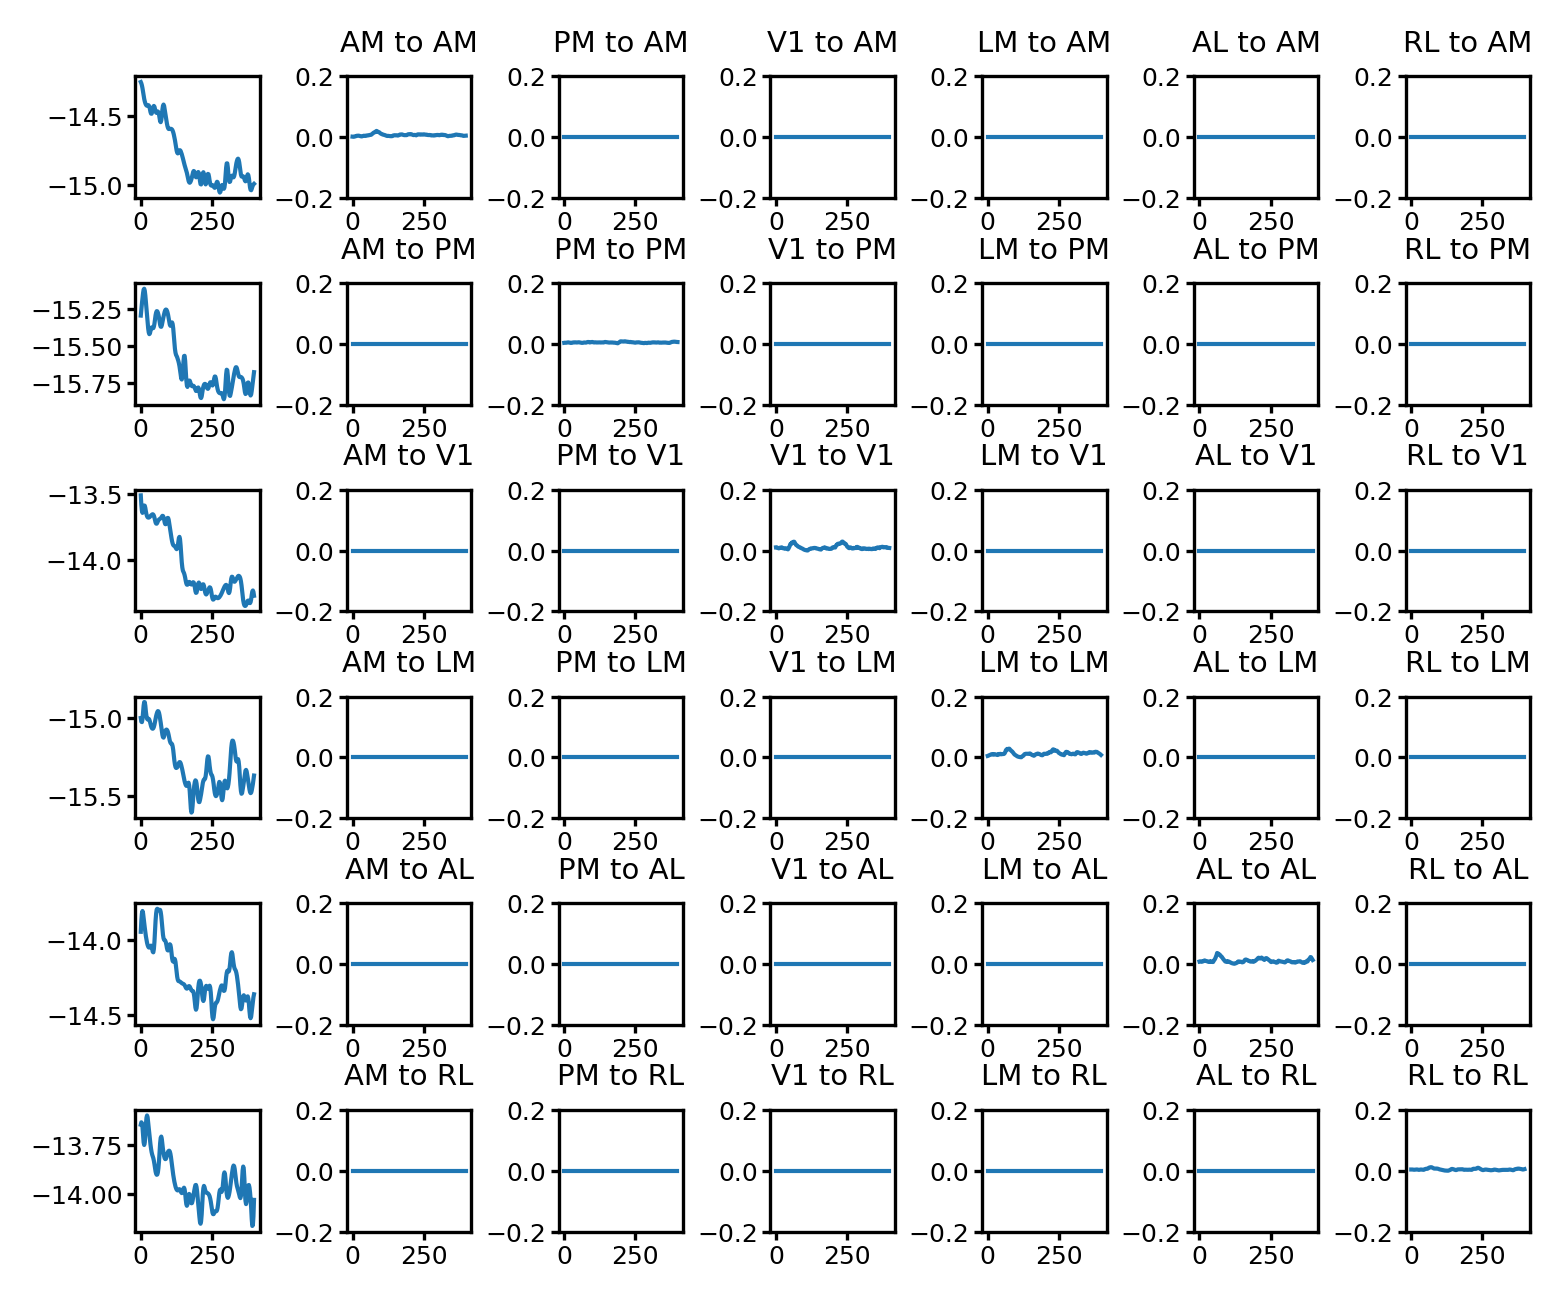

In [12]:
### Plot mean coupling output from area i (or baseline) to area j, averaged across trials and neurons
plot_session = str(757216464)

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
utils.use_pdf_plot()

area_names = list(utils.PROBE_CORRESPONDING.values())
xxx = 2*np.arange(trainer.model.coupling_outputs[0][1].shape[2])

fig = plt.figure(figsize=(6, 5), dpi=300)
outer = GridSpec(6, 7, figure=fig, wspace=0.7, hspace=0.7)
axes = np.empty((6, 7), dtype=object)
for i in range(6):
    for j in range(7):
        if (i, j) not in []:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])
for j in range(6):
    for i in range(7):
        if i == 0:
            # Plot baseline
            neuron_start = trainer.model.accnneuron_dict[plot_session][j]
            neuron_end = trainer.model.accnneuron_dict[plot_session][j+1]
            outputs = trainer.model.firing_rates_stimulus[:,neuron_start:neuron_end,:].detach().cpu().numpy()
            axes[j,i].plot(xxx, outputs.mean(axis=(0,1)))
            # axes[j,i].set_title(f'Baseline {area_names[j]}')
            # axes[j,i].set_xlabel('Time (ms)')
            # axes[j,i].set_ylabel('log firing rate')
            # axes[j,i].set_ylim(-5, 0)
            # axes[j,i].set_xticks([0, 200, 400])
            
        else:
            # Plot coupling
            outputs = trainer.model.coupling_outputs[i-1][j].detach().cpu().numpy()
            axes[j,i].plot(xxx, outputs.mean(axis=(0,1)))
            axes[j,i].set_title(f'{area_names[i-1]} to {area_names[j]}')
            # axes[j,i].set_xlabel('Time (ms)')
            # axes[j,i].set_ylabel('log firing rate')
            axes[j,i].set_ylim(-0.2, 0.2)
            # axes[j,i].set_xticks([0, 200, 400])
            # axes[j,i].set_yticks([-2, 0, 2])
            


In [13]:
trainer.model.accnneuron_dict[plot_session]

[0, 64, 124, 209, 262, 315, 352]